# AnyoneAI - Sprint Project 01
> E-Commerce Data Pipeline

In this notebook we will first execute all the components of our ELT pipeline and then plot visualizations with the resulting information.


In [1]:
# Importing the necessary libraries
from pandas import DataFrame
from sqlalchemy import create_engine
from typing import Dict
from pathlib import Path

from src.transform import QueryEnum
from src import config
from src.transform import run_queries
from src.extract import extract
from src.load import load
from src.plots import (
    plot_freight_value_weight_relationship,
    plot_global_amount_order_status,
    plot_real_vs_predicted_delivered_time,
    plot_revenue_by_month_year,
    plot_revenue_per_state,
    plot_top_10_least_revenue_categories,
    plot_top_10_revenue_categories,
    plot_top_10_revenue_categories_ammount,
    plot_delivery_date_difference,
    plot_order_amount_per_day_with_holidays,
)

In [2]:
# Create the database sql file
Path(config.SQLITE_BD_ABSOLUTE_PATH).touch()

# Create the database connection
ENGINE = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

### 1. Extract

Here you will be extracting the information from different sources.

In [3]:
csv_folder = config.DATASET_ROOT_PATH
public_holidays_url = config.PUBLIC_HOLIDAYS_URL

# 1. Get the mapping of the csv files to the table names.
csv_table_mapping = config.get_csv_to_table_mapping()

# 2. Extract the data from the csv files, holidays and load them into the dataframes.
csv_dataframes = extract(csv_folder, csv_table_mapping, public_holidays_url)

La solicitud fue exitosa, sin errores en la respuesta


### 2. Load

Using the diferent datasets provided to you, you will store everything into our Data Warehouse.

In [4]:
load(data_frames=csv_dataframes, database=ENGINE)

### 3. Transform

Here you will be transforming the different queries into tables. There are two sections, one with the revenue related queries, and another with the delivery related queries.

##### 3.1 Revenue queries

In [5]:
query_results: Dict[str, DataFrame] = run_queries(database=ENGINE)

c:\Users\Victoria\Documents\Victoria\Cursos\ML Developer - AnyoneAI\SprintProject1\ASSIGNMENT\src\transform.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dates['filtered_dates_day'] = filtered_dates[
c:\Users\Victoria\Documents\Victoria\Cursos\ML Developer - AnyoneAI\SprintProject1\ASSIGNMENT\src\transform.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['holiday'][result_df['holiday']!=False] = True
c:\Users\Victoria\Documents\Victoria\Cursos\ML Developer - AnyoneAI\SprintProject1\ASSIGNMENT\src\transform.py:192: FutureWarning: Th

In [6]:
# Transforming the revenue_by_month_year query to a table
revenue_by_month_year = query_results[QueryEnum.REVENUE_BY_MONTH_YEAR.value]
revenue_by_month_year

,month_no,month,Year2016,Year2017,Year2018
0,01,Jan,0.00,37632.57,969967.80
1,02,Feb,0.00,222270.75,853616.82
2,03,Mar,0.00,376833.72,1024851.95
3,04,Apr,0.00,299798.45,1274742.18
4,05,May,0.00,579280.43,1150528.93
5,06,Jun,0.00,489463.42,1141543.85
6,07,Jul,0.00,518115.19,925958.79
7,08,Aug,0.00,609180.34,1319737.66
8,09,Sep,0.00,652576.48,12875.18
9,10,Oct,34116.28,740570.40,347.95


In [7]:
# Transforming the top_10_revenue_categories query to a table
top_10_revenue_categories = query_results[QueryEnum.TOP_10_REVENUE_CATEGORIES.value]
top_10_revenue_categories

,Category,Num_order,Revenue
0,bed_bath_table,9272,1692714.28
1,health_beauty,8646,1620684.04
2,computers_accessories,6529,1549252.47
3,furniture_decor,6307,1394466.93
4,watches_gifts,5493,1387046.31
5,sports_leisure,7529,1349252.93
6,housewares,5743,1069787.97
7,auto,3809,833610.84
8,garden_tools,3448,810614.93
9,cool_stuff,3559,744649.32


In [8]:
# Transforming the top_10_least_revenue_categories query to a table
top_10_least_revenue_categories = query_results[
    QueryEnum.TOP_10_LEAST_REVENUE_CATEGORIES.value
]
top_10_least_revenue_categories

,Category,Num_order,Revenue
0,security_and_services,2,324.51
1,fashion_childrens_clothes,7,718.98
2,cds_dvds_musicals,12,1199.43
3,home_comfort_2,24,1710.54
4,flowers,29,2213.01
5,arts_and_craftmanship,23,2326.17
6,la_cuisine,13,2913.53
7,fashion_sport,26,3605.83
8,diapers_and_hygiene,25,4126.17
9,fashio_female_clothing,36,4902.67


In [9]:
# Transforming the revenue_per_state query to a table
revenue_per_state = query_results[QueryEnum.REVENUE_PER_STATE.value]
revenue_per_state

,customer_state,Revenue
0,SP,5769081.27
1,RJ,2055690.45
2,MG,1819277.61
3,RS,861608.40
4,PR,781919.55
5,SC,595208.40
6,BA,591270.60
7,DF,346146.17
8,GO,334294.22
9,ES,317682.65


In [10]:
# Transforming the revenue_per_state query to a table

import sqlite3
import numpy as np
import pandas as pd

conexion = sqlite3.connect('olist.db')

cursor = conexion.cursor()

cursor.execute(f"""
    SELECT customer_state,SUM(payment_value) AS Revenue FROM olist_customers
    INNER JOIN olist_orders
    ON olist_customers.customer_id = olist_orders.customer_id
    INNER JOIN olist_order_payments
    ON olist_orders.order_id = olist_order_payments.order_id
    WHERE order_delivered_customer_date IS NOT NULL AND
    order_status = 'delivered'
    GROUP BY customer_state
    ORDER BY Revenue DESC
    LIMIT 10
""")

print(np.array(cursor.fetchall()))

conexion.close()

[['SP' '5769081.269999902']
 ['RJ' '2055690.4499999913']
 ['MG' '1819277.61000001']
 ['RS' '861608.3999999964']
 ['PR' '781919.5499999981']
 ['SC' '595208.4000000015']
 ['BA' '591270.6000000015']
 ['DF' '346146.17000000004']
 ['GO' '334294.2200000007']
 ['ES' '317682.65000000066']]


##### 3.2 Delivery queries

In [11]:
# Transforming the delivery_date_difference query to a table
delivery_date_difference = query_results[QueryEnum.DELIVERY_DATE_DIFFERECE.value]
delivery_date_difference

,State,Delivery_Difference
0,AL,8
1,MA,9
2,BA,10
3,CE,10
4,ES,10
5,SE,10
6,MS,11
7,PI,11
8,RJ,11
9,SC,11


In [12]:
# Transforming the real vs predicted delivered time query to a table per month and year
real_vs_estimated_delivered_time = query_results[
    QueryEnum.REAL_VS_ESTIMATED_DELIVERED_TIME.value
]
real_vs_estimated_delivered_time

,month_no,month,Year2016_real_time,Year2017_real_time,Year2018_real_time,Year2016_estimated_time,Year2017_estimated_time,Year2018_estimated_time
0,01,Jan,NaN,12.647044,14.080563,NaN,39.508831,26.302555
1,02,Feb,NaN,13.168825,16.945138,NaN,31.848929,24.528996
2,03,Mar,NaN,12.951184,16.301410,NaN,24.732386,22.033067
3,04,Apr,NaN,14.917913,11.499241,NaN,27.349810,23.679546
4,05,May,NaN,11.322363,11.419029,NaN,24.284784,22.891488
5,06,Jun,NaN,12.011573,9.239216,NaN,24.021864,27.772740
6,07,Jul,NaN,11.592732,8.958636,NaN,23.317316,19.690127
7,08,Aug,NaN,11.147125,7.732780,NaN,23.480603,15.186330
8,09,Sep,54.813194,11.851007,NaN,18.488449,22.437366,NaN
9,10,Oct,19.600559,11.856700,NaN,55.676632,23.019536,NaN


In [13]:
# Transforming the global ammount of order status query to a table
global_ammount_order_status = query_results[QueryEnum.GLOBAL_AMMOUNT_ORDER_STATUS.value]
global_ammount_order_status

,order_status,Ammount
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [14]:
orders_per_day_and_holidays = query_results[
    QueryEnum.ORDERS_PER_DAY_AND_HOLIDAYS_2017.value
]
orders_per_day_and_holidays

,order_count,date,holiday
0,32,2017-01-05,False
1,4,2017-01-06,False
2,4,2017-01-07,False
3,6,2017-01-08,False
4,5,2017-01-09,False
...,...,...,...
356,167,2017-12-27,False
357,146,2017-12-28,False
358,135,2017-12-29,False
359,97,2017-12-30,False


In [15]:
freight_value_weight_relationship = query_results[
    QueryEnum.GET_FREIGHT_VALUE_WEIGHT_RELATIONSHIP.value
]

### 4. Plotting the query tables

Now, we will create plots from the different queries

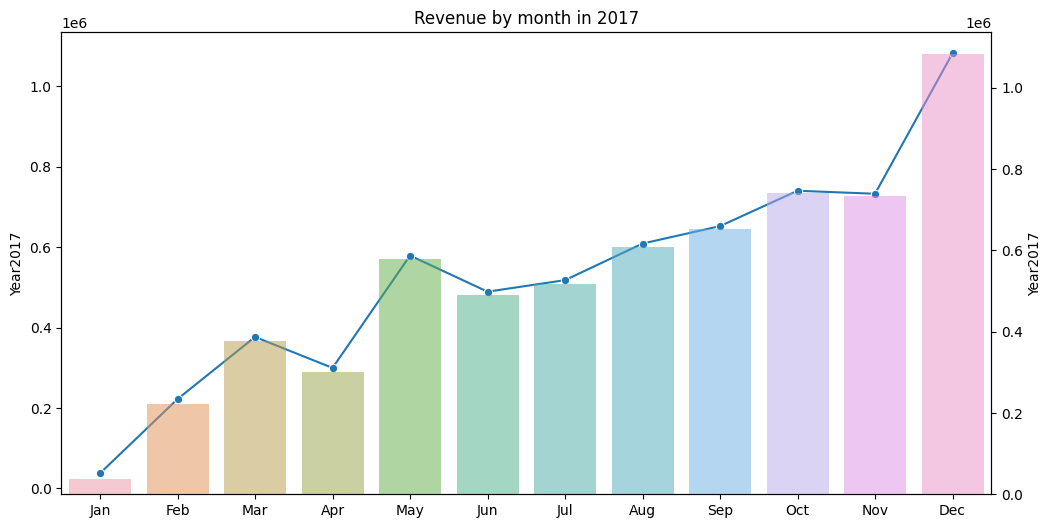

In [16]:
plot_revenue_by_month_year(revenue_by_month_year, 2017)

In [17]:
plot_top_10_revenue_categories(top_10_revenue_categories)

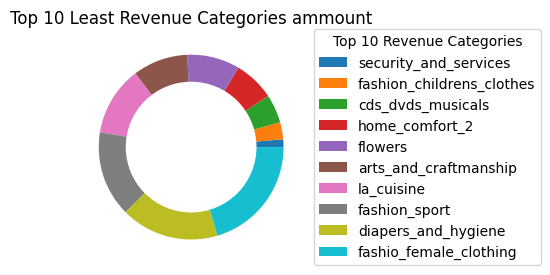

In [18]:
plot_top_10_least_revenue_categories(top_10_least_revenue_categories)

In [19]:
plot_revenue_per_state(revenue_per_state)

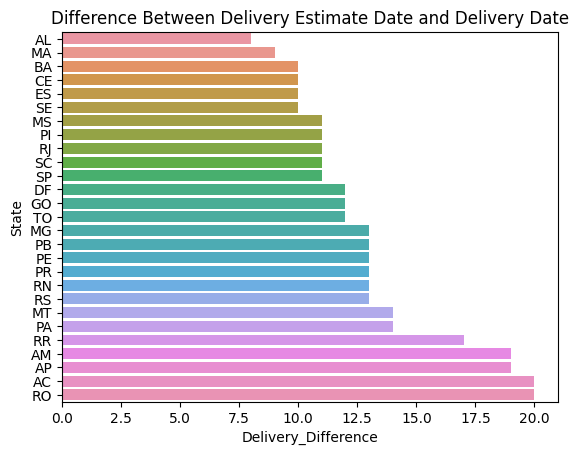

In [20]:
plot_delivery_date_difference(delivery_date_difference)

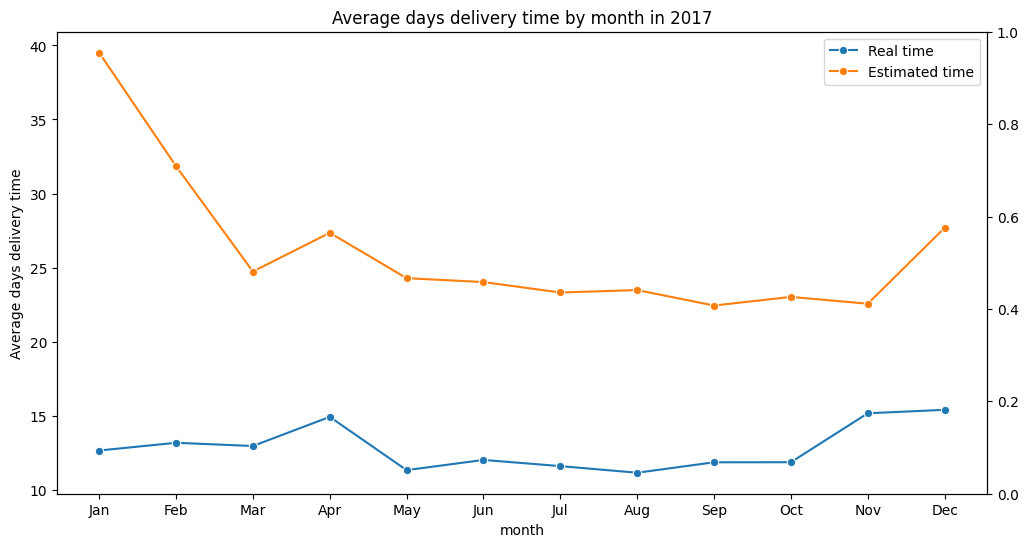

In [21]:
plot_real_vs_predicted_delivered_time(real_vs_estimated_delivered_time, year=2017)

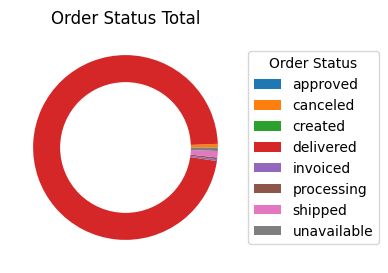

In [22]:
plot_global_amount_order_status(global_ammount_order_status)

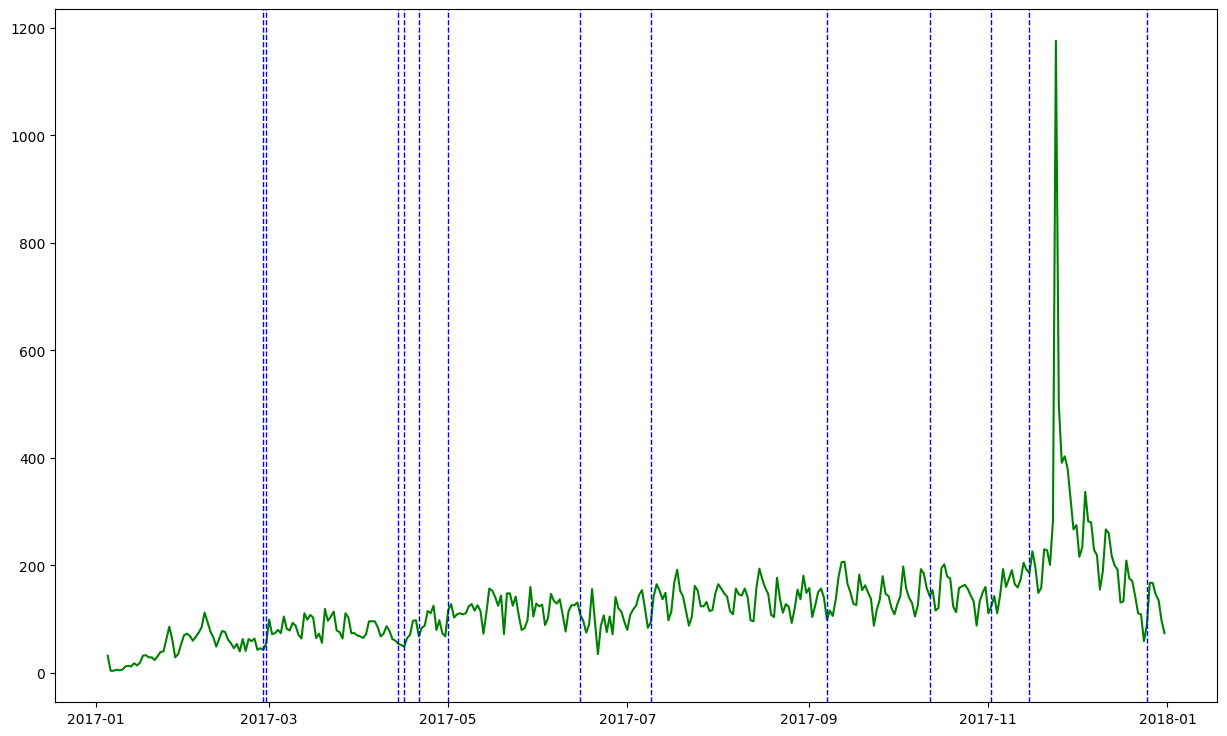

In [23]:
plot_order_amount_per_day_with_holidays(orders_per_day_and_holidays)

The Orders per Day and Holidays plot you will code in src/plots.py has to be similar to this:

![The plot you will code will be similar to this:](images/orders_per_day_and_holidays.png "Orders per Day and Holidays")

4.1 Do you see any relationship between the Brazilian public holidays of 2017 and that year's purchases?

<AxesSubplot: xlabel='product_weight_g', ylabel='freight_value'>

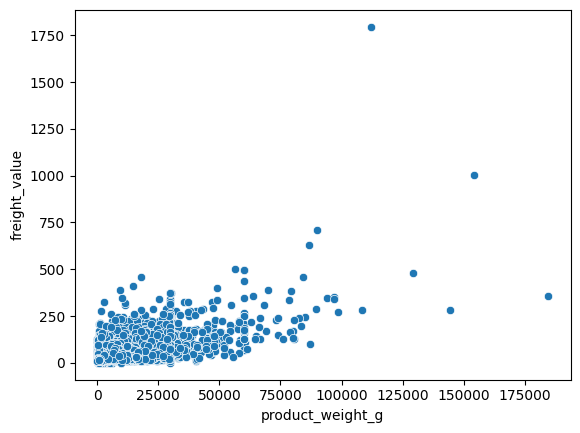

In [24]:
plot_freight_value_weight_relationship(freight_value_weight_relationship)

The Freight Value and Weight Relationship plot you will code in src/plots.py has to be similar to this:

![The plot you will code will be similar to this:](images/freight_value_weight_relationship.png "Freight Value and Weight Relationship")

4.2 Do you see any correlation between the freight value and the product weight?

Yes, there is a directly proportional relationship between freight_value and weight_value_g